In [1]:
import os
import sys
import csv
import yaml
import json

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv2D,Dropout,MaxPooling2D
from keras.layers import Flatten,Lambda,Cropping2D,BatchNormalization
from keras.callbacks import ModelCheckpoint,TensorBoard

Using TensorFlow backend.


In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
img = os.listdir('./IMG/')

In [7]:
len(img)

158319

In [8]:
image = mpimg.imread(os.path.join('IMG',img[0]))

In [11]:
flipped = np.flip(image,axis=1)

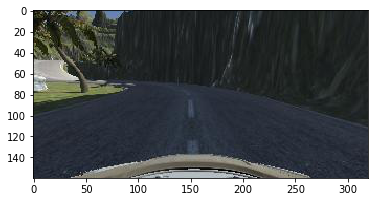

In [16]:
plt.imshow(image[])
plt.show()

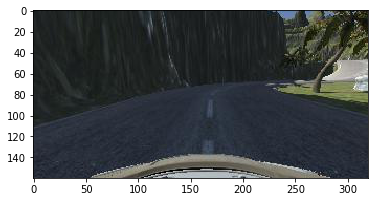

In [12]:
plt.imshow(flipped)
plt.show()

In [15]:
if not os.path.exists('IMG/f'):
    print(1)

1


In [6]:
CF = 0.27
LR = 1e-3
DECAY = 0.99
samples = pd.read_csv('driving_log.csv')

In [7]:
steering_center = samples.steering
steering_left = steering_center + CF 
steering_right = steering_center - CF

steering_angle = np.concatenate((steering_center,steering_left,steering_right))

In [8]:
center_images = list(samples.center)
left_images = list(samples.left)
right_images = list(samples.right)

sample_images = []
sample_images += center_images
sample_images += left_images
sample_images += right_images

In [9]:
X_data = sample_images
y_data = steering_angle

X_train,X_validation,y_train,y_validation = train_test_split(X_data,y_data,test_size=0.2)

X_train,y_train = shuffle(X_train,y_train)

In [10]:
def flipped(data,measurement_angle):
    return np.flip(data,axis=1),measurement_angle*(-1)

train_data = {'X':X_train,'y':y_train}
validation_data = {'X':X_validation,'y':y_validation}

In [11]:
def generator(data,batch_size):
    
    num_samples = len(data['X'])
    xdata,ydata = data['X'],data['y']
    
    while True:
        for offset in range(0,num_samples,batch_size):
            xbatch_samples = xdata[offset:offset+batch_size]
            ybatch_samples = ydata[offset:offset+batch_size]
            
            images = []
            for batch_sample in xbatch_samples:
                img = mpimg.imread(os.path.join('IMG',batch_sample))
                images.append(img)
    
            
            X_batch = np.array(images)
            y_batch = ybatch_samples
            yield shuffle(X_batch,y_batch)

In [12]:
train_generator = generator(train_data,batch_size=32) 
validation_generator = generator(validation_data,batch_size=32)

In [14]:
### Alexnet Structure

alexnet_model = Sequential()

alexnet_model.add(Cropping2D(cropping=((65,40),(0,0)),
                     input_shape=(160,320,3)))
alexnet_model.add(Lambda(lambda x:K.tf.image.resize_images(x,(224,224),
                                                      method=K.tf.image.ResizeMethod.NEAREST_NEIGHBOR)))
alexnet_model.add(Lambda(lambda x:((x-K.mean(x))/K.std(x))))
alexnet_model.add(Conv2D(96,(11,11),strides=(4,4),padding='same',
                     activation='elu'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

alexnet_model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='elu'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

alexnet_model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='elu'))

alexnet_model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='elu'))

alexnet_model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='elu'))
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

alexnet_model.add(Flatten())

alexnet_model.add(Dense(100,activation='elu'))
alexnet_model.add(Dense(50,activation='elu'))
alexnet_model.add(Dense(10,activation='elu'))
alexnet_model.add(Dense(1))

In [15]:
alexnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 55, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

In [15]:
adam = Adam(lr=LR,decay=DECAY)
alexnet_model.compile(loss='mse',optimizer=adam)

alexnet_model.fit_generator(train_generator,
                        steps_per_epoch=len(X_train)/128,
                        callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                                   TensorBoard(log_dir='./logdir/',
                                               histogram_freq=1,
                                               batch_size=32,
                                               write_grads=True)],
                        validation_data=validation_generator,
                        validation_steps=len(X_validation)/128,
                        epochs=5)

alexnet_model.save('alexnet_model_k2.h5')

Epoch 1/5
469/468 [==============================] - 287s - loss: 0.5945 - val_loss: 0.0894
Epoch 2/5
469/468 [==============================] - 272s - loss: 0.0847 - val_loss: 0.0848
Epoch 3/5
469/468 [==============================] - 273s - loss: 0.0816 - val_loss: 0.0823
Epoch 4/5
469/468 [==============================] - 271s - loss: 0.0795 - val_loss: 0.0805
Epoch 5/5
469/468 [==============================] - 274s - loss: 0.0779 - val_loss: 0.0790


In [16]:
nvidia_model = Sequential()
nvidia_model.add(Cropping2D(cropping=((65,40),(0,0)),input_shape=(160,320,3)))
nvidia_model.add(Lambda(lambda x:K.tf.image.resize_images(x,(66,200),
                                                          method=K.tf.image.ResizeMethod.NEAREST_NEIGHBOR)))
nvidia_model.add(Lambda(lambda x:((x-K.mean(x))/K.std(x))))
nvidia_model.add(Conv2D(24,(5,5),strides=(2,2),activation='elu',padding='valid'))
nvidia_model.add(Conv2D(36,(5,5),strides=(2,2),activation='elu',padding='valid'))
nvidia_model.add(Conv2D(48,(5,5),strides=(2,2),activation='elu',padding='valid'))
nvidia_model.add(Conv2D(64,(3,3),strides=(1,1),activation='elu',padding='valid'))
nvidia_model.add(Conv2D(64,(3,3),strides=(1,1),activation='elu',padding='valid'))
nvidia_model.add(Activation('elu'))

nvidia_model.add(Flatten())
nvidia_model.add(Dense(100,activation='elu'))
nvidia_model.add(Dense(50,activation='elu'))
nvidia_model.add(Dense(10,activation='elu'))
nvidia_model.add(Dense(1))

adam = Adam(lr=LR,decay=DECAY)
nvidia_model.compile(loss='mse',optimizer=adam)

In [17]:
nvidia_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 55, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
__________

In [14]:
nvidia_model.fit_generator(train_generator,
                    steps_per_epoch=len(X_train)/128,
                    callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                               TensorBoard(log_dir='./logdir/',
                                           histogram_freq=1,
                                           batch_size=32,
                                           write_grads=True)],
                    validation_data=validation_generator,
                    validation_steps=len(X_validation)/128,
                    epochs=5)

nvidia_model.save('model_k2.h5')

Epoch 1/2
469/468 [==============================] - 212s - loss: 0.0962 - val_loss: 0.0894
Epoch 2/2
469/468 [==============================] - 204s - loss: 0.0892 - val_loss: 0.0903


In [18]:
#ZFNet MOdel Architecture
zfnet_model = Sequential()
zfnet_model.add(Cropping2D(cropping=((65,40),(0,0)),input_shape=(160,320,3)))
zfnet_model.add(Lambda(lambda x:K.tf.image.resize_images(x,(224,224),
                                                         method=K.tf.image.ResizeMethod.NEAREST_NEIGHBOR)))
zfnet_model.add(Lambda(lambda x:((x-K.mean(x))/K.std(x))))
zfnet_model.add(Conv2D(96,(7,7),strides=(2,2),padding='same',
                     activation='elu'))
zfnet_model.add(BatchNormalization())
zfnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

zfnet_model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='elu'))
zfnet_model.add(BatchNormalization())
zfnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

zfnet_model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='elu'))

zfnet_model.add(Conv2D(1024,(3,3),strides=(1,1),padding='same',activation='elu'))

zfnet_model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='elu'))
zfnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

zfnet_model.add(Flatten())

zfnet_model.add(Dense(100,activation='elu'))
zfnet_model.add(Dense(50,activation='elu'))
zfnet_model.add(Dense(10,activation='elu'))
zfnet_model.add(Dense(1))

adam = Adam(lr=LR,decay=DECAY)
zfnet_model.compile(loss='mse',optimizer=adam)

In [19]:
zfnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 55, 320, 3)        0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 96)      14208     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 96)      384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 55, 55, 256)       614656    
__________

In [ ]:
zfnet_model.fit_generator(train_generator,
                          steps_per_epoch=len(X_train)/32,
                          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                                     TensorBoard(log_dir='./logdir/',
                                                 histogram_freq=1,
                                                 batch_size=32,
                                                 write_grads=True)],
                          validation_data=validation_generator,
                          validation_steps=len(X_validation)/32,
                          epochs=5)

zfnet_model.save('zfnet_model_k2.h5')

In [18]:
vgg_model = Sequential()
vgg_model.add(Cropping2D(cropping=((65,40),(0,0)),input_shape=(160,320,3)))
vgg_model.add(Lambda(lambda x:K.tf.image.resize_images(x,(224,224),
                                                       method=K.tf.image.ResizeMethod.NEAREST_NEIGHBOR)))
vgg_model.add(Lambda(lambda x:((x-K.mean(x))/K.std(x))))
vgg_model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(64,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(MaxPooling2D(strides=(1,1),padding='valid'))
vgg_model.add(Conv2D(128,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(128,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(MaxPooling2D(strides=(1,1),padding='valid'))
vgg_model.add(Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(256,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(MaxPooling2D(strides=(1,1),padding='valid'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(MaxPooling2D(strides=(1,1),padding='valid'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(Conv2D(512,(3,3),strides=(1,1),padding='valid',activation='relu'))
vgg_model.add(MaxPooling2D(strides=(1,1),padding='valid'))
vgg_model.add(Flatten())
vgg_model.add(Dense(100,activation='relu'))
vgg_model.add(Dense(50,activation='relu'))
vgg_model.add(Dense(10,activation='relu'))
vgg_model.add(Dense(1))

In [19]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_4 (Cropping2D)    (None, 55, 320, 3)        0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 224, 224, 128)     73856     
__________

In [20]:
from keras.models import Model,Sequential

In [22]:
from keras.applications import InceptionV3

In [23]:
incep = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3))

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: conv2d_9/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3323024, _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_9/random_uniform/shape)]]

Caused by op 'conv2d_9/random_uniform/RandomUniform', defined at:
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-a35bfcf7f7a8>", line 17, in <module>
    vgg_model.add(Conv2D(512,(3,3),activation='relu'))
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/models.py", line 469, in add
    output_tensor = layer(self.outputs[0])
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3536, in random_uniform
    dtype=dtype, seed=seed)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 249, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: conv2d_9/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3323024, _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_9/random_uniform/shape)]]
